# Imports

In [1]:
!pip install pyemd
!pip install fuzzywuzzy
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.2 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149874 sha256=acd478ba0b8b8653cd4fbddcdf04cfa2f43f3e3f975eb72ad5344261b98946e3
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [4]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd 
import numpy as np
from tqdm import tqdm
import pickle
import os
import regex as re
import string
from collections import defaultdict, Counter
from copy import deepcopy
import gc

import scipy.stats as stats
from scipy import sparse
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import nltk
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
# from fuzzywuzzy import fuzz

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import gensim
from gensim import models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import warnings
warnings.filterwarnings("ignore")

from drive.MyDrive.Quora_Duplicate_Questions.src.functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Downloads

In [8]:
def set_seed(seed):
    """
    Sets a global random seed of your choice
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
set_seed(69)

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

PATH = 'drive/MyDrive/Quora_Duplicate_Questions/'
data = pd.read_csv(PATH+'src/train.csv', index_col='id')
col_list = data.columns.tolist()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Fuzzywuzzy Features

In [6]:
data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(
    str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_Wratio'] = data.apply(lambda x: fuzz.WRatio(
    str(x['question1']), str(x['question2'])), axis=1)

data['fuzz_partial_ratio'] = data.apply(lambda x: 
fuzz.partial_ratio(str(x['question1']), 
str(x['question2'])), axis=1)

data['fuzz_partial_token_set_ratio'] = data.apply(lambda x:
fuzz.partial_token_set_ratio(str(x['question1']), 
str(x['question2'])), axis=1)

data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: 
fuzz.partial_token_sort_ratio(str(x['question1']), 
str(x['question2'])), axis=1)

data['fuzz_token_set_ratio'] = data.apply(lambda x: 
fuzz.token_set_ratio(str(x['question1']), 
str(x['question2'])), axis=1)

data['fuzz_token_sort_ratio'] = data.apply(lambda x: 
                   fuzz.token_sort_ratio(str(x['question1']), 
                   str(x['question2'])), axis=1)

fs_2 = ['fuzz_qratio', 'fuzz_Wratio', 'fuzz_partial_ratio', 
       'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio',
       'fuzz_token_set_ratio', 'fuzz_token_sort_ratio']

# data[fs_2].to_csv(PATH+'src/feat_set_2.csv', index='id')

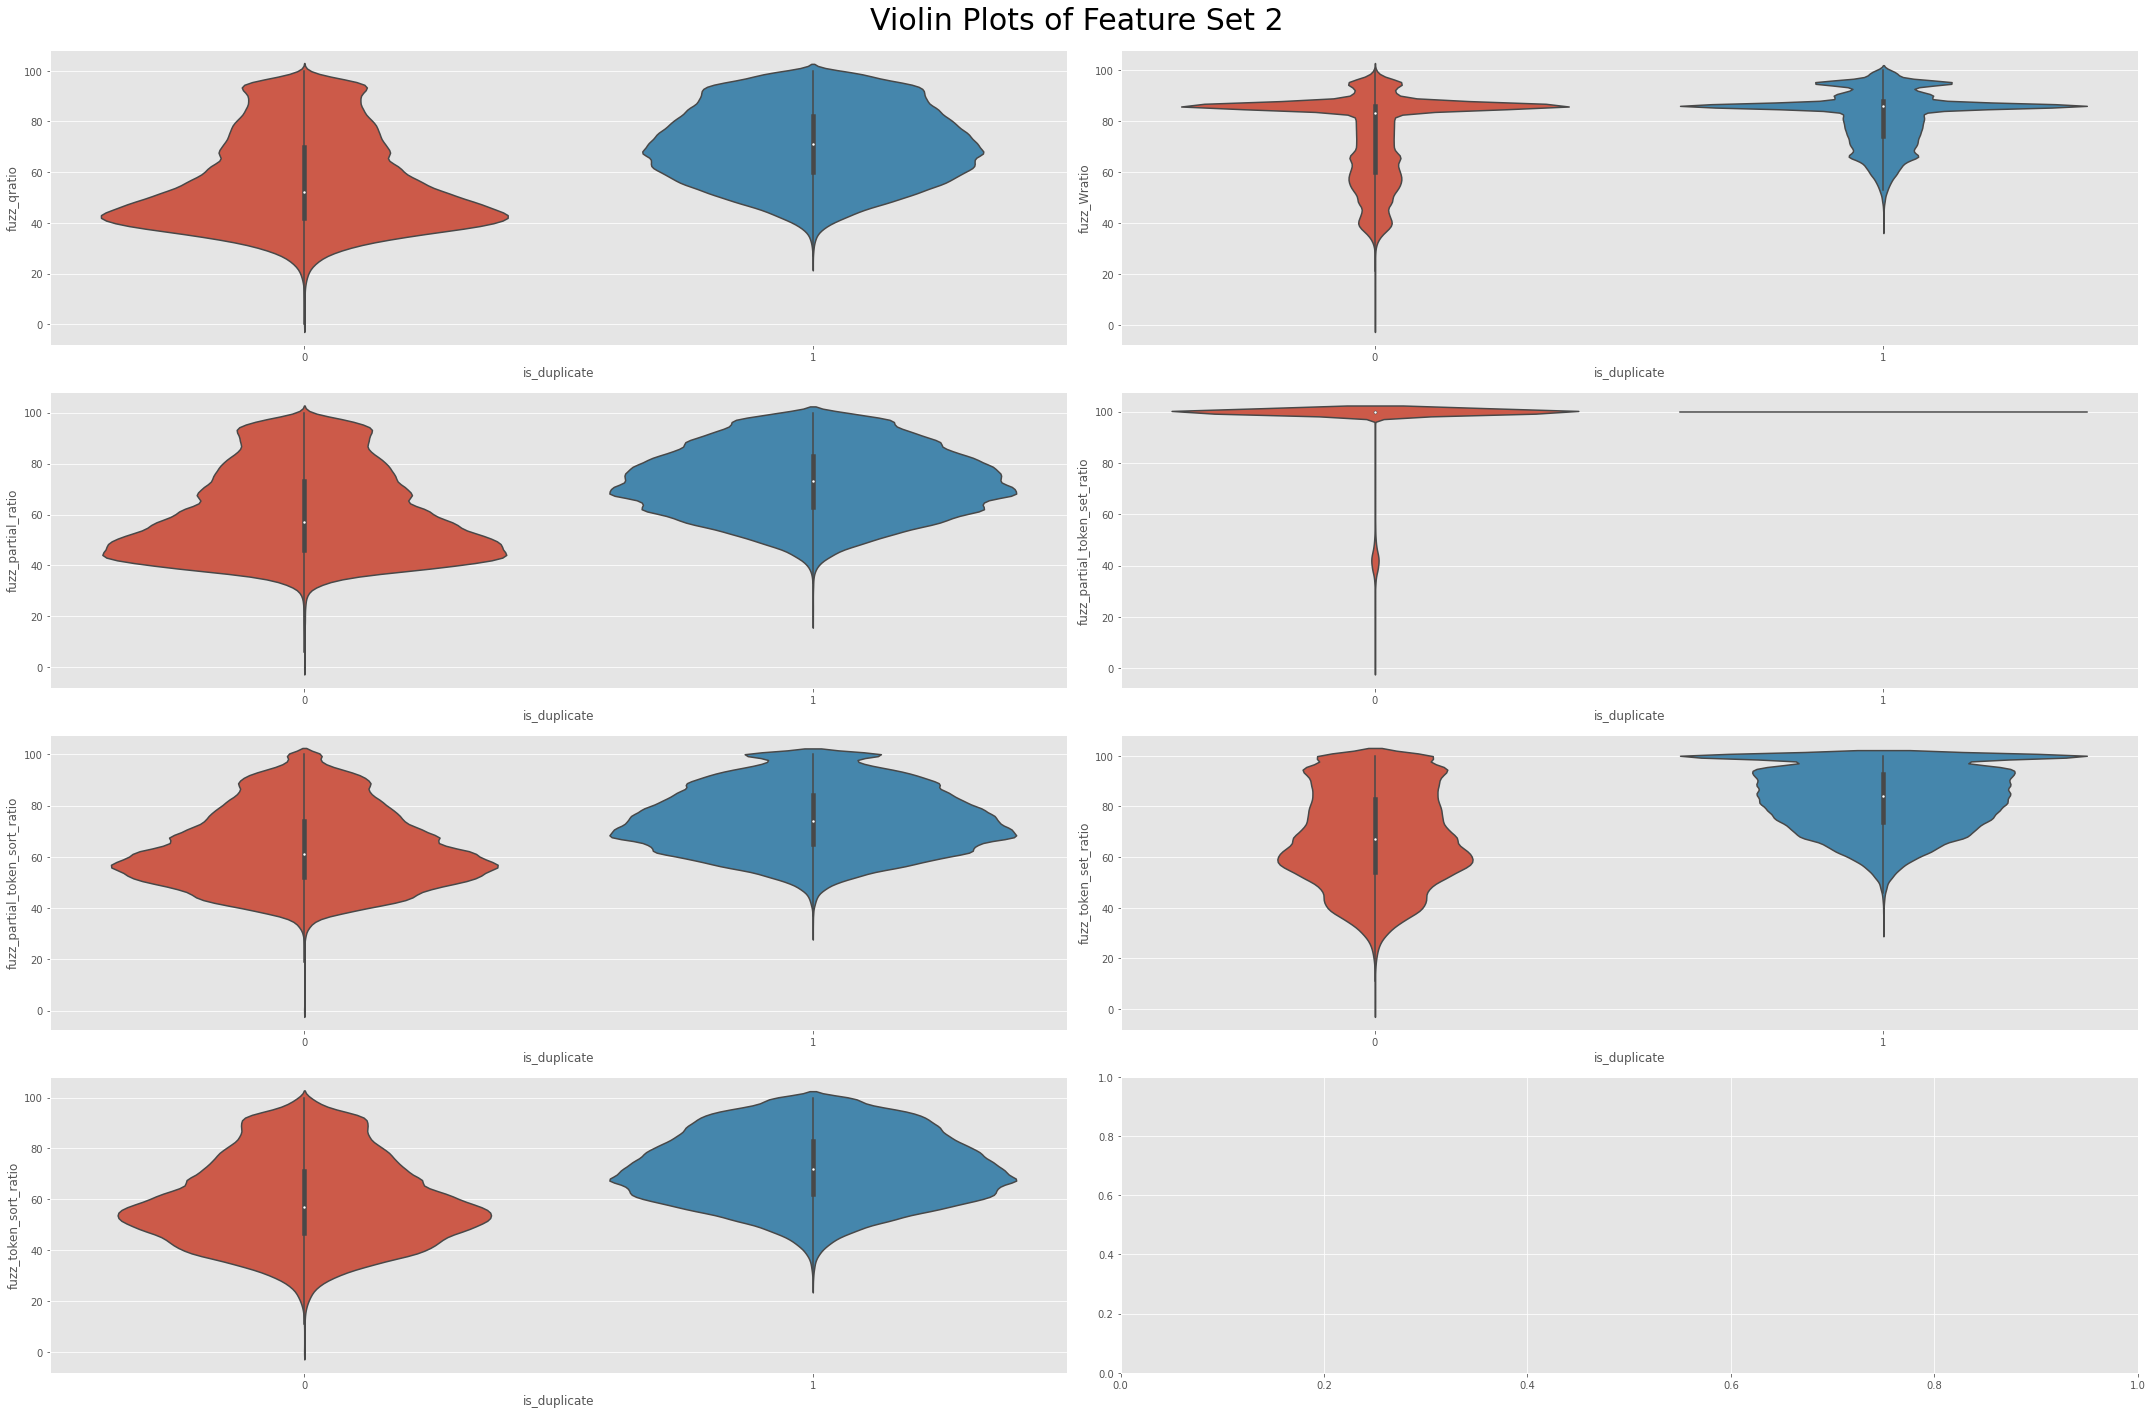

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(30, 20))
axes = axes.ravel()
for ax, feature in zip(axes, fs_2):
    sns.violinplot(data=data, x='is_duplicate', y=feature, ax=ax)
plt.suptitle('Violin Plots of Feature Set 2', fontsize=30)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

# TF-idf + Truncated SVD Features

In [ ]:
tfv_q1 = TfidfVectorizer(
    min_df=3, 
    max_features=None, 
    strip_accents='unicode', 
    analyzer='word', 
    token_pattern=r'w{1,}',
    ngram_range=(1, 2), 
    use_idf=1, 
    smooth_idf=1, 
    sublinear_tf=1,
    stop_words='english'
    )

tfv_q2 = deepcopy(tfv_q1)
q1_tfidf = tfv_q1.fit_transform(data['question1'].fillna(" "))
q2_tfidf = tfv_q2.fit_transform(data['question2'].fillna(" "))
fs3_1 = sparse.hstack((q1_tfidf, q2_tfidf))

In [ ]:
svd_q1 = TruncatedSVD(n_components=10)
svd_q2 = TruncatedSVD(n_components=10)

question1_vectors = svd_q1.fit_transform(q1_tfidf)
question2_vectors = svd_q2.fit_transform(q2_tfidf)
fs3_3 = np.hstack((question1_vectors, question2_vectors))

In [ ]:
tfv = TfidfVectorizer(min_df=3, 
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word', 
                      token_pattern=r'w{1,}',
                      ngram_range=(1, 2), 
                      use_idf=1, 
                      smooth_idf=1, 
                      sublinear_tf=1,
                      stop_words='english')
# combine questions and calculate tf-idf
q1q2 = data['question1'].fillna(" ") 
q1q2 += " " + data['question2'].fillna(" ")
fs3_2 = tfv.fit_transform(q1q2)

svd_q1q2 = TruncatedSVD(n_components=10)
fs3_4 = svd_q1q2.fit_transform(fs3_1)
fs3_5 = svd_q1q2.fit_transform(fs3_2)

In [6]:
!gzip -d /content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz

In [ ]:
pickle.dump(fs3_1, open(PATH+'src/fs3_1.pkl', 'wb'))
pickle.dump(fs3_2, open(PATH+'src/fs3_2.pkl', 'wb'))
pickle.dump(fs3_3, open(PATH+'src/fs3_3.pkl', 'wb'))
pickle.dump(fs3_4, open(PATH+'src/fs3_4.pkl', 'wb'))
pickle.dump(fs3_5, open(PATH+'src/fs3_5.pkl', 'wb'))

# GoogleNews Word2Vec Embeddings

In [ ]:
model = models.KeyedVectors.load_word2vec_format(
    '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin', binary=True)

gc.collect()

def sent2vec(s, model): 
    M = []
    words = word_tokenize(str(s).lower())
    for word in words:
        #It shouldn't be a stopword
        if word not in stop_words:
            #nor contain numbers
            if word.isalpha():
                #and be part of word2vec
                if word in model:
                    M.append(model[word])
    M = np.array(M)
    if len(M) > 0:
        v = M.sum(axis=0)
        return v / np.sqrt((v ** 2).sum())
    else:
        return np.zeros(300)

w2v_q1 = np.array([sent2vec(q, model) 
                   for q in data.question1])
w2v_q2 = np.array([sent2vec(q, model) 
                   for q in data.question2])

w2v = np.hstack((w2v_q1, w2v_q2))

In [11]:
M

NameError: ignored

In [ ]:
pickle.dump(w2v, open('w2v.pkl', 'wb'))

# Distances

In [ ]:
data['cosine_distance'] = [cosine(x,y) 
for (x,y) in zip(w2v_q1, w2v_q2)]
data['cityblock_distance'] = [cityblock(x,y) 
for (x,y) in zip(w2v_q1, w2v_q2)]
data['jaccard_distance'] = [jaccard(x,y) 
for (x,y) in zip(w2v_q1, w2v_q2)]
data['canberra_distance'] = [canberra(x,y) 
for (x,y) in zip(w2v_q1, w2v_q2)]
data['euclidean_distance'] = [euclidean(x,y) 
for (x,y) in zip(w2v_q1, w2v_q2)]
data['minkowski_distance'] = [minkowski(x,y,3) 
for (x,y) in zip(w2v_q1, w2v_q2)]
data['braycurtis_distance'] = [braycurtis(x,y) 
for (x,y) in zip(w2v_q1, w2v_q2)]

fs4_1 = ['cosine_distance', 'cityblock_distance', 
         'jaccard_distance', 'canberra_distance', 
         'euclidean_distance', 'minkowski_distance',
         'braycurtis_distance']

In [ ]:
data[fs4_1].to_csv(PATH+'src/fs4_1.csv', index='id')

# Word Movers Distance

In [ ]:
def wmd(s1, s2, model):
    s1 = str(s1).lower().split()
    s2 = str(s2).lower().split()
    stop_words = stopwords.words('english')
    s1 = [w for w in s1 if w not in stop_words]
    s2 = [w for w in s2 if w not in stop_words]
    return model.wmdistance(s1, s2)

data['wmd'] = data.apply(lambda x: wmd(x['question1'], 
x['question2'], model), axis=1)
model.init_sims(replace=True) 
data['norm_wmd'] = data.apply(lambda x: wmd(x['question1'], 
x['question2'], model), axis=1)
fs4_2 = ['wmd', 'norm_wmd']